<a href="https://colab.research.google.com/github/DinisMartinho/Image-Colorizer/blob/main/NeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q jmd_imagescraper
import torch, torchvision, tqdm, numpy, matplotlib.pyplot, os, PIL, matplotlib.image
from jmd_imagescraper.core import *
%matplotlib inline

     |████████████████████████████████| 1.6 MB 45.7 MB/s 


In [2]:
# GPU is preferable to run the notebook.
use_collab_gpu = True #@param {type:"boolean"}

In [3]:
if use_collab_gpu == True:
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
  device = torch.device("cpu")

In [4]:
# Scrape images from the internet to use to train our neural network.
data_dir = "./data/"

search_results = ["instagram models", "men's fashion models",
                  "beautiful interiors", "selfies", "instagram selfies",
                  "women's fashion models", "fashion", "old houses",
                  "portuguese houses", "historical places",
                  "parks", "big gardens", "photos of the sky",
                  "city buildings", "beaches", "girls",
                  "guys", "cool cars on a street", "trees",
                  "public parks", "amazing natural designs", "forests",
                  "animals"]
    
print("You will download a total of " + str(len(search_results)*300))

You will download a total of 6900


In [ ]:
for i in search_results:
  duckduckgo_search(data_dir, i, i, max_results=300)

In [28]:
# Transform the scraped images into usable training data.
data_transforms = [torchvision.transforms.Resize(64),
  torchvision.transforms.CenterCrop(64),
  torchvision.transforms.ToTensor()]

train_ds = torchvision.datasets.ImageFolder(data_dir, transform=torchvision.transforms.Compose(data_transforms))
len(train_ds)

6896

In [29]:
# Create a data loader.
data_loader = torch.utils.data.DataLoader(dataset=train_ds, batch_size=64, num_workers=2, shuffle=True)

In [8]:
class NeuralNetwork(torch.nn.Module):
  def __init__(self):
    super().__init__()

    self.inp_enc = torch.nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=1)
    self.enc_enc = torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=1)
    
    self.enc_lat = torch.nn.Conv2d(in_channels=64, out_channels=256, kernel_size=(3,3), stride=(2,2), padding=1)
    self.lat_lat = torch.nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=1)

    self.lat_dec = torch.nn.ConvTranspose2d(in_channels=256, out_channels=64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    self.dec_dec = torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=1)
    self.dec_out = torch.nn.Conv2d(in_channels=64, out_channels=3, kernel_size=(3,3), stride=(1,1), padding=1)

    # [Activation Functions]
    self.sigmoid = torch.nn.Sigmoid()
    self.relu = torch.nn.ReLU(inplace=True)

  def forward(self, i):
    # Encoder
    x = self.inp_enc(i)
    x = self.relu(x)
    for i in range(6):
      x = self.enc_enc(x)
      x = self.relu(x)
    
    # Latent
    x = self.enc_lat(x)
    x = self.relu(x)
    for i in range(30):
      x = self.lat_lat(x)
      x = self.relu(x)
    
    # Decoder
    x = self.lat_dec(x)
    x = self.relu(x)
    for i in range(12):
      x = self.dec_dec(x)
      x = self.relu(x)
    x = self.dec_out(x)
    x = self.sigmoid(x)
    
    return x

In [9]:
# Create the training function.
def Train(model, device, num_epochs, learning_rate, loss_function, optimizer, data_loader):
  ToGrayscale = torchvision.transforms.Grayscale()
  for epochs in range(num_epochs):
    loop = tqdm.tqdm(enumerate(data_loader))
    for i, (x, _) in loop:
          # Forward Pass
          x = x.to(device) 
          y = ToGrayscale(x) 
          output = model(y)

          # Compute Loss
          reconstruction_loss = loss_function(output, x)

          # Backpropagation
          loss = reconstruction_loss
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          loop.set_postfix(loss=loss.item())

In [10]:
model = NeuralNetwork().to(device)

In [14]:
# Lets run the training function and start training the model.
num_epochs = 5 #@param {type:"integer"}
learning_rate = 3e-4 #@param {type:"number"}

loss_func = torch.nn.BCELoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
Train(model=model, device=device, num_epochs=num_epochs,
      learning_rate=learning_rate, loss_function=loss_func, optimizer=optimizer,
      data_loader=data_loader)

108it [01:50,  1.03s/it, loss=4.09e+5]
108it [01:50,  1.03s/it, loss=4.09e+5]
108it [01:51,  1.03s/it, loss=4.09e+5]
108it [01:51,  1.04s/it, loss=4.09e+5]
108it [01:51,  1.03s/it, loss=4.09e+5]


In [ ]:
# Now you can save your trained model
torch.save(model.state_dict(), "./htl.pth")

In [19]:
# or load an already trained one.
model.load_state_dict(torch.load("./htl.pth"))

<All keys matched successfully>

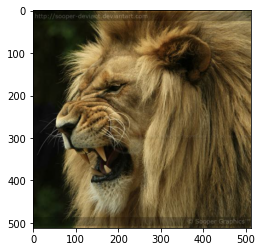

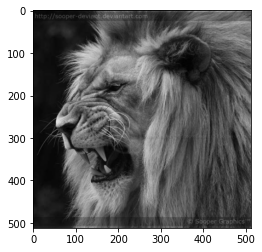

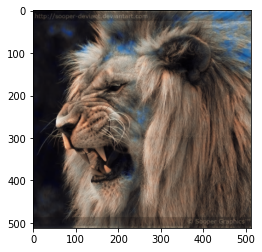

In [27]:
# With our model trained, just input any 
# grayscale image and let your model do its magic.
for i, (x, _) in (enumerate(data_loader)):
  GrayscaleImage = torchvision.transforms.Grayscale()(x).to(device)
  output_image = model(GrayscaleImage)

  paths = ["original.png", "grayscale.png", "output.png"]
  
  torchvision.utils.save_image(x,               paths[0])
  torchvision.utils.save_image(GrayscaleImage,  paths[1])
  torchvision.utils.save_image(output_image,    paths[2])

  for i in paths:
    img = matplotlib.image.imread(i)
    imgplot = matplotlib.pyplot.imshow(img)
    matplotlib.pyplot.show()
  break